# LAB 2

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import clear_output

import logging
import os

import mlflow
import mlflow.sklearn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

from joblib import dump, load
from fedot.api.main import Fedot
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
import pickle
from tpot import TPOTClassifier

### Загрузка данных

In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
df = pd.read_csv(url, names=column_names)

df

,sepal_length,sepal_width,petal_length,petal_width,species
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
146,6.7,3.0,5.2,2.3,Iris-virginica
147,6.3,2.5,5.0,1.9,Iris-virginica
148,6.5,3.0,5.2,2.0,Iris-virginica
149,6.2,3.4,5.4,2.3,Iris-virginica


### Анализ данных

In [4]:
print(df.describe())
print('_'*60)
print(df.info())
print('_'*60)
print(df['species'].value_counts())

       sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000
____________________________________________________________
<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 150
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    ob

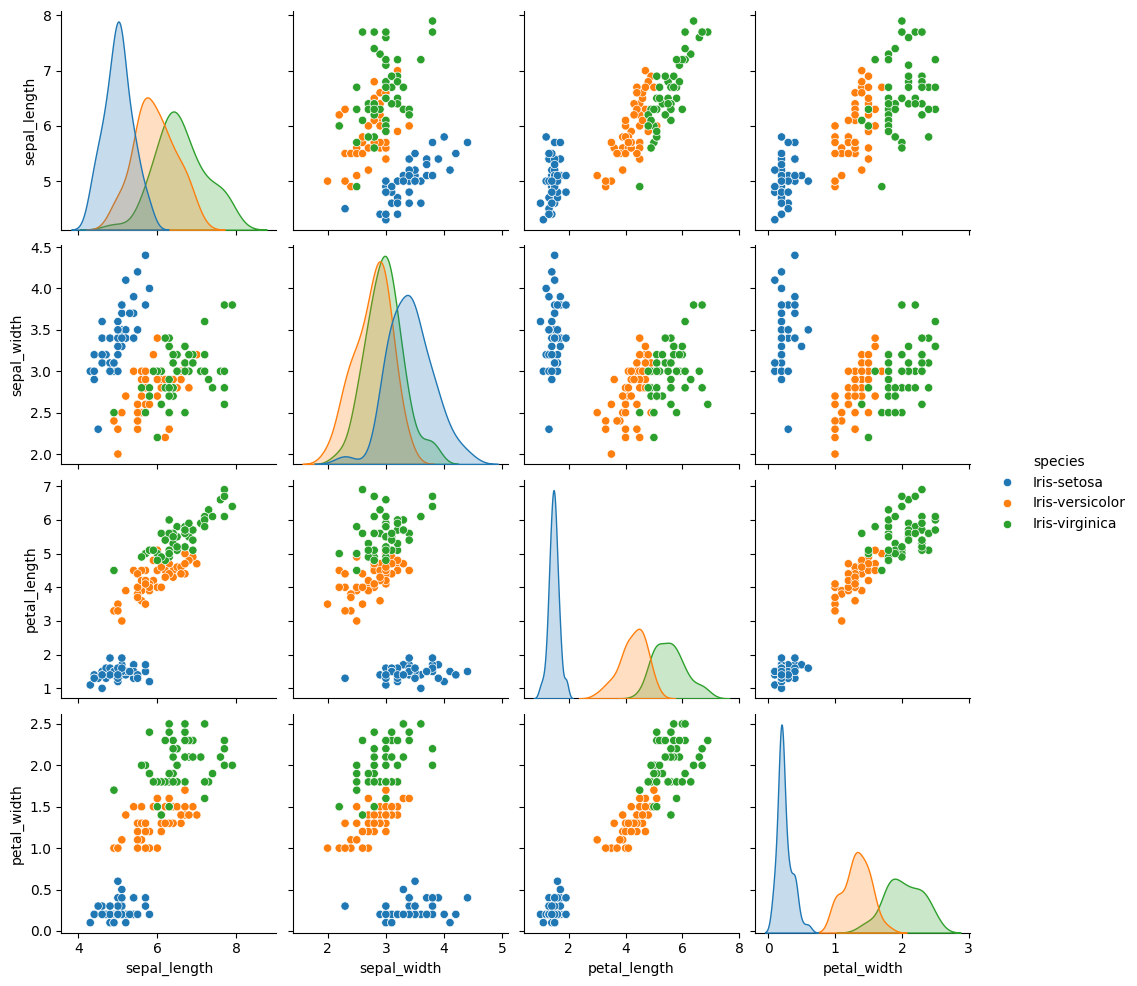

In [5]:
sns.pairplot(df, hue='species')
plt.show()

Таким образом можно сделать вывод, что датасет содержит 3 класса, которые сбалансированы и довольно легко визуально-разделимы

### Построение LogisticRegression для бинарной классификации элементов датасета, на примере данных (versicolor и virginica)

In [6]:
df_binary = df[df['species'].isin(['Iris-virginica', 'Iris-versicolor'])].copy()
df_binary['species'] = df_binary['species'].map({'Iris-virginica': 0, 'Iris-versicolor': 1})

In [7]:
X = df_binary.drop('species', axis=1)
y = df_binary['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70, 4), (30, 4), (70,), (30,))

In [8]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [9]:
accuracy, precision, recall = (
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred),
    recall_score(y_test, y_pred),
)
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

Accuracy: 0.9, Precision: 1.0, Recall: 0.8235294117647058


### Переобучение модели линейной регрессии

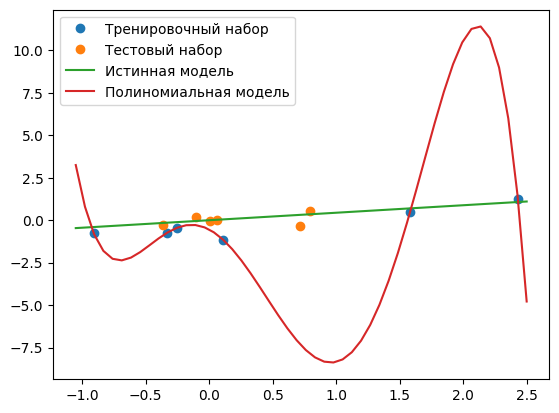

In [10]:
# Установка семени для воспроизводимости результатов
np.random.seed(5)

# Параметры моделирования
n_features = 1  # количество признаков (фичей)
n_samples = 6   # количество образцов в тренировочном наборе

# Генерация данных для тренировочного набора
w_true = np.random.randn(n_features)  # истинные веса модели
X_train = np.random.randn(n_samples, n_features)
y_train = X_train @ w_true + np.random.randn(n_samples)

# Генерация данных для валидационного набора
X_val = np.random.randn(n_samples, n_features)
y_val = X_val @ w_true + np.random.randn(n_samples)

# Генерация данных для тестового набора
X_test = np.random.randn(n_samples, n_features)
y_test = X_test @ w_true + np.random.randn(n_samples)

# Генерация полиномиального набора данных
x_begin = -1.05
x_end = 2.5
n_polynomial_terms = 5  # количество членов в полиноме
X_polynomial = np.hstack([np.ones((n_samples, 1)), X_train ** np.arange(1, n_polynomial_terms + 1)])
w_polynomial = np.linalg.inv(X_polynomial.T @ X_polynomial) @ X_polynomial.T @ y_train
y_polynomial = [
    np.array([x**i for i in range(n_polynomial_terms + 1)]) @ w_polynomial for x in np.linspace(x_begin, x_end)
]

# Визуализация данных
plt.plot(X_train, y_train, 'o', label='Тренировочный набор')
plt.plot(X_test, y_test, 'o', label='Тестовый набор')
plt.plot(np.linspace(x_begin, x_end), w_true * np.linspace(x_begin, x_end), '-', label='Истинная модель')
plt.plot(np.linspace(x_begin, x_end), y_polynomial, '-', label='Полиномиальная модель')

# Добавление легенды и отображение графика
plt.legend(loc='best')
plt.show()

**Что такое переобучение, и как с ним бороться?**
Переобучение (overfitting) — это явление, когда модель обучается слишком хорошо на тренировочном наборе данных и плохо справляется с новыми данными. Это происходит из-за того, что модель становится слишком сложной и начинает учиться на шумах или случайных вариациях в данных.

Существет множество методов борьбы с переобучением, вот некотоые из них:

> 1. Упрощение модели: Сокращение количества параметров модели или использования более простой структуры. Например, вместо полиномиальной модели можно использовать линейную.

> 2. Регуляризация: Добавление небольшого значения к весам модели для предотвращения чрезмерного увеличения их величины. Это может быть сделано с помощью L1-регуляризации (Lasso) или L2-регуляризации (Ridge).

> 3. Понижение степени свободы: Уменьшение количества степеней свободы модели, что можно сделать с помощью методов снижения размерности, таких как PCA (Principal Component Analysis) или t-SNE.

> 4. Кросс-валидация: Разделение данных на тренировочный и тестовый наборы для оценки качества модели.

> 5. Early Stopping: Остановка обучения модели при достижении определенного показателя качества на тестовом наборе.

> 6. Дропаут: Удаление случайных нейронов или слоев во время обучения, чтобы предотвратить чрезмерное увеличение сложности модели.

> 7. Батч-нормализация: Нормализация входных данных для каждого батча (мини-блока) во время обучения, что помогает уменьшить влияние шума в данных.

> 8. Использование более простых функций активации: Использование функций активации, которые не имеют чрезмерного увеличения сложности, такие как ReLU или Sigmoid.

### Обогащение датасета

Нам уже был известен способ обогащения `SMOTE`, который используется для устранения дисбаланса классов. Ниже нами был реализован метод, со схожим механизмом генерации новых экземпляров через выпуклые комбинации пар точек, но расширяющий все классы, а не только меньший из них.

**Суть метода**
Метод создаёт **новые синтетические экземпляры** для каждого класса в датасете Iris, комбинируя пары реальных точек **выпуклой линейной комбинацией**.

**Как это работает?**  
1. **Выбор двух случайных точек из одного класса**  
   - Для каждого класса (например, `Iris-setosa`) берутся две случайные точки \( A \) и \( B \).  
   - Их признаки (длина/ширина чашелистиков и лепестков) рассматриваются как векторы в 4-мерном пространстве.  
2. **Вычисление выпуклой комбинации**  
   - Генерируется случайный коэффициент \(alpha in [0, 1] \).  
   - Новая точка \( C \) вычисляется как:  
     \[
     C = alpha * A + (1 - alpha) * B
     \]  
   - Это означает, что \( C \) лежит **на отрезке между \( A \) и \( B \)** в пространстве признаков.  
3. **Сохранение класса**  
   - Новая точка \( C \) наследует метку класса от \( A \) и \( B \), так как они принадлежат одному классу. 

**Геометрическая интерпретация**  
- В **пространстве признаков** (например, в 2D-проекции `sepal_length` vs `petal_length`):  
  - Исходные точки образуют **облако (кластер)**.  
  - Новые точки заполняют **выпуклую оболочку** этого кластера, **не выходя за его границы**.  

- Если исходные точки лежат в некотором многообразии (например, на гиперплоскости), новые точки также останутся в нём.

In [11]:
# Функция для генерации выпуклых комбинаций

def generate_convex_combinations(group, num_combinations=1):
    new_samples = []
    n = len(group)
    if n < 2:
        return pd.DataFrame()
    
    features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
    for _ in range(num_combinations):
        idx1, idx2 = np.random.choice(n, 2, replace=False)
        sample1 = group.iloc[idx1]
        sample2 = group.iloc[idx2]
        
        alpha = np.random.uniform(0, 1)
        
        new_features = alpha * sample1[features] + (1 - alpha) * sample2[features]
        
        new_sample = new_features.to_dict()
        new_sample['species'] = sample1['species']
        new_samples.append(new_sample)
    
    return pd.DataFrame(new_samples)

In [12]:
augmented_dfs = []
for species in df['species'].unique():
    species_group = df[df['species'] == species]
    augmented_samples = generate_convex_combinations(species_group, num_combinations=len(species_group)//2)  # Удваиваем размер каждого класса
    augmented_dfs.append(species_group)
    augmented_dfs.append(augmented_samples)

augmented_df = pd.concat(augmented_dfs, ignore_index=True)

print(f"Original size: {len(df)}")
print(f"Augmented size: {len(augmented_df)}")
print(augmented_df['species'].value_counts())

Original size: 150
Augmented size: 225
Iris-setosa        75
Iris-versicolor    75
Iris-virginica     75
Name: species, dtype: int64


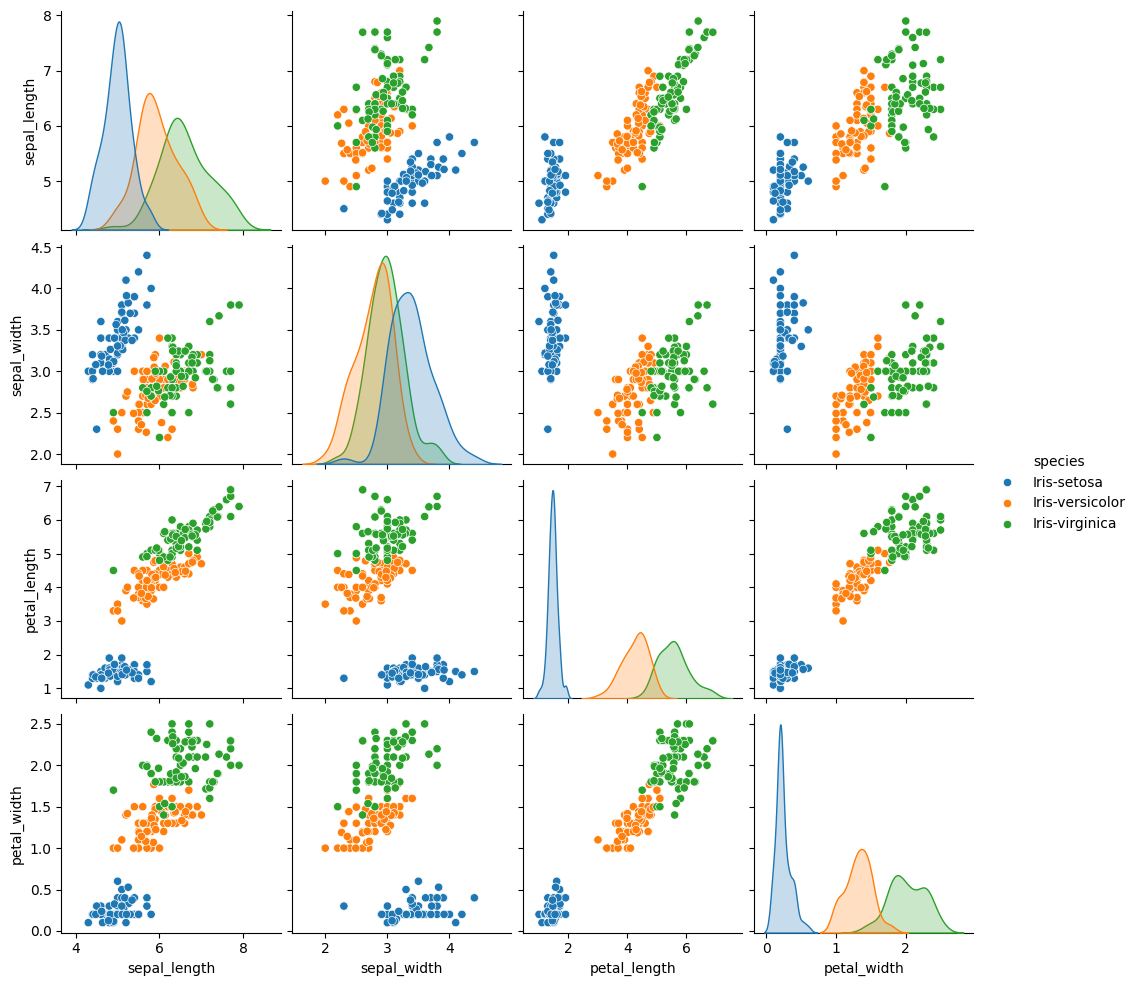

In [13]:
sns.pairplot(augmented_df, hue='species')
plt.show()

Как видно на графиках, распределения не поменялись, изменилось лишь количество экземпляров каждого из 3 классов

# LAB3 AutoML

In [14]:
directory = 'autoML_models'
if not os.path.exists(directory):
    os.makedirs(directory)
    print(f'directory "{directory}" was created')
else:
    print(f'directory "{directory}" already exists')

directory "autoML_models" was created


### Lama

In [15]:
X = augmented_df.drop('species', axis=1)

mapper = {
    'Iris-virginica': 0,
    'Iris-versicolor': 1,
    'Iris-setosa': 2
}
y = augmented_df['species'].replace(mapper)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

task = Task('multiclass')

automl = TabularAutoML(
    task=task,
    cpu_limit=-1,
    general_params={'use_algos': 'auto'},
    reader_params={'cv': 3, 'random_state': 42}
)

train_data = pd.concat([X_train, y_train], axis=1)
roles = {
    'target': 'species',
    'drop': []
}

oof_pred = automl.fit_predict(
    train_data=train_data,
    roles=roles,
    verbose=1
)

test_pred = automl.predict(X_test)
y_pred = test_pred.data.argmax(axis=1)

accuracy, precision, recall = (
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred, average='weighted'),
    recall_score(y_test, y_pred, average='weighted'),
)

clear_output(wait=False)
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

Accuracy: 1.0, Precision: 1.0, Recall: 1.0


In [16]:
with open(f'{directory}/lightautoml_iris_model.pkl', 'wb') as f:
    pickle.dump(automl, f)

with open(f'{directory}/lightautoml_iris_model.pkl', 'rb') as f:
    loaded_automl = pickle.load(f)

new_pred = loaded_automl.predict(X_test).data.argmax(axis=1)
accuracy, precision, recall = (
    accuracy_score(y_test, new_pred),
    precision_score(y_test, new_pred, average='weighted'),
    recall_score(y_test, new_pred, average='weighted'),
)
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

Accuracy: 1.0, Precision: 1.0, Recall: 1.0


In [17]:
try:
    algo = loaded_automl.levels[0][0].ml_algos[0]
    print(f"Тип алгоритма: {type(algo).__name__}")
    
    if hasattr(algo, 'models'):
        model = algo.models[0]
        print(f"Тип модели: {type(model).__name__}")
        attrs_to_show = [attr for attr in dir(model) if not attr.startswith('_')]

        print(f"\n=== Параметры {type(model).__name__} ===")
        for attr in attrs_to_show:
            try:
                value = getattr(model, attr)
                
                if attr == 'model':
                    print("\nАрхитектура нейросети:")
                    print(value)
                elif attr == 'loss':
                    print(f"\nФункция потерь: {value.__class__.__name__}")
                else:
                    print(f"{attr}: {value}")
                    
            except Exception as e:
                print(f"{attr}: [не доступен]")

except Exception as e:
    print(f"Ошибка: {str(e)}")
    print("Используйте альтернативный метод:")
    print(loaded_automl.print_model_info())

Тип алгоритма: LinearLBFGS
Тип модели: TorchBasedLogisticRegression

=== Параметры TorchBasedLogisticRegression ===
categorical_idx: []
cs: [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]
data_size: 4
early_stopping: 2
embed_sizes: ()
fit: <bound method TorchBasedLinearEstimator.fit of <lightautoml.ml_algo.torch_based.linear_model.TorchBasedLogisticRegression object at 0x000001FC4C3C3CD0>>

Функция потерь: TorchLossWrapper
max_iter: 100
metric: <lightautoml.tasks.losses.base.MetricFunc object at 0x000001FC4A542160>

Архитектура нейросети:
CatMulticlass(
  (linear): Linear(in_features=4, out_features=3, bias=False)
  (final_act): SoftmaxClip(
    (smax): Softmax(dim=1)
  )
)
output_size: 3
predict: <bound method TorchBasedLogisticRegression.predict of <lightautoml.ml_algo.torch_based.linear_model.TorchBasedLogisticRegression object at 0x000001FC4C3C3CD0>>
tol: 1e-06


### Fedot

In [18]:
X = augmented_df.drop('species', axis=1)
y = augmented_df['species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
# Инициализация Fedot с явным указанием доступных моделей
automl_model = Fedot(
    problem='classification',
    preset='fast_train',
    # timeout=10,  # 2 минуты на подбор
    available_operations=['rf', 'logit','mlp', 'xgboost'],
    logging_level=logging.CRITICAL,
    with_tuning=True,
    n_jobs=-1,
    seed=42
)

try:
    pipeline = automl_model.fit(features=X_train, target=y_train)
    
    y_pred = automl_model.predict(features=X_test)
    
    accuracy, precision, recall = (
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average='weighted'),
        recall_score(y_test, y_pred, average='weighted'),
    )
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

    
except Exception as e:
    print(f'Произошла ошибка: {str(e)}')
    print('Попробуйте обновить Fedot или использовать другой пресет')

2025-03-31 19:56:24,811 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'


Generations:   0%|          | 49/10000 [02:29<8:27:11,  3.06s/gen] 


Accuracy: 1.0, Precision: 1.0, Recall: 1.0


In [20]:
def get_pipeline_info(pipeline):
    """Рекурсивно получает информацию о пайплайне"""
    info = []
    
    def process_node(node, level=0):
        indent = "  " * level
        node_info = {
            'type': str(node.operation.operation_type),
            'params': getattr(node, 'parameters', {}),
            'level': level,
            'node_object': node  # Сохраняем сам объект узла
        }
        info.append(node_info)
        
        if hasattr(node, 'nodes_from'):
            for parent in node.nodes_from:
                process_node(parent, level + 1)
    
    process_node(pipeline.root_node if hasattr(pipeline, 'root_node') else pipeline)
    return info

best_pipeline = automl_model.current_pipeline
pipeline_info = get_pipeline_info(best_pipeline)

for item in pipeline_info:
    print(f"{'  ' * item['level']}Узел: {item['type']}")
    print(f"{'  ' * item['level']}Параметры: {item['params']}")
    
    node = item['node_object']
    try:
        if hasattr(node, 'fitted_operation'):
            fitted_params = node.fitted_operation.get_params()
            print('Fitted_params: {')
            for param in fitted_params:
                print(f'\t{param}: {fitted_params[param]}')
            print('}')
    except Exception as e:
        print(f'Не удалось получить fitted параметры: {str(e)}')

Узел: mlp
Параметры: {}
Fitted_params: {
	activation: relu
	alpha: 0.0001
	batch_size: auto
	beta_1: 0.9
	beta_2: 0.999
	early_stopping: False
	epsilon: 1e-08
	hidden_layer_sizes: (100,)
	learning_rate: constant
	learning_rate_init: 0.001
	max_fun: 15000
	max_iter: 200
	momentum: 0.9
	n_iter_no_change: 10
	nesterovs_momentum: True
	power_t: 0.5
	random_state: None
	shuffle: True
	solver: adam
	tol: 0.0001
	validation_fraction: 0.1
	verbose: False
	warm_start: False
}


In [21]:
with open(f'{directory}/fedot_model.pkl', 'wb') as f:
    pickle.dump(automl_model, f)

with open(f'{directory}/fedot_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

y_pred = loaded_model.predict(features=X_test)

accuracy, precision, recall = (
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred, average='weighted'),
    recall_score(y_test, y_pred, average='weighted'),
)
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

Accuracy: 1.0, Precision: 1.0, Recall: 1.0


### TPOT

In [22]:
tpot = TPOTClassifier(generations=5, population_size=20, random_state=42, verbosity=2)
tpot.fit(X_train, y_train)

Version 0.12.1 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


                                                                             
Generation 1 - Current best internal CV score: 0.9888888888888889
                                                                             
Generation 2 - Current best internal CV score: 0.9888888888888889
                                                                             
Generation 3 - Current best internal CV score: 0.9888888888888889
                                                                              
Generation 4 - Current best internal CV score: 0.9888888888888889
                                                                              
Generation 5 - Current best internal CV score: 0.9888888888888889
                                                                              
Best pipeline: MLPClassifier(input_matrix, alpha=0.001, learning_rate_init=0.01)


TPOTClassifier(generations=5, population_size=20, random_state=42, verbosity=2)

In [23]:
y_pred = tpot.predict(X_test)
accuracy, precision, recall = (
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred, average='weighted'),
    recall_score(y_test, y_pred, average='weighted'),
)

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

Accuracy: 1.0, Precision: 1.0, Recall: 1.0


In [24]:
final_pipeline = tpot.fitted_pipeline_

dump(final_pipeline, f'{directory}/final_pipeline.joblib')
loaded_pipeline = load(f'{directory}/final_pipeline.joblib')

y_pred = loaded_pipeline.predict(X_test)
accuracy, precision, recall = (
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred, average='weighted'),
    recall_score(y_test, y_pred, average='weighted'),
)

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

Accuracy: 1.0, Precision: 1.0, Recall: 1.0


In [25]:
loaded_pipeline = load(f'{directory}/final_pipeline.joblib')

for step_name, step_estimator in loaded_pipeline.steps:
    print(f"Тип: {type(step_estimator).__name__}")
    params = step_estimator.get_params()
    print("Параметры:")
    for el in params:
        print(f'\t{el}: {params[el]}')

Тип: MLPClassifier
Параметры:
	activation: relu
	alpha: 0.001
	batch_size: auto
	beta_1: 0.9
	beta_2: 0.999
	early_stopping: False
	epsilon: 1e-08
	hidden_layer_sizes: (100,)
	learning_rate: constant
	learning_rate_init: 0.01
	max_fun: 15000
	max_iter: 200
	momentum: 0.9
	n_iter_no_change: 10
	nesterovs_momentum: True
	power_t: 0.5
	random_state: 42
	shuffle: True
	solver: adam
	tol: 0.0001
	validation_fraction: 0.1
	verbose: False
	warm_start: False


# Lab4 MLFlow

Подготовка примеров для проверки решения целевой задачи по прогнозированию и оценка качества моделей была проведена выше.
Метрики полученных ранее моделей имеют максимальное значние, так как задача классификации Iris крайне проста. В связи с этим.

Перейдём к визуализации

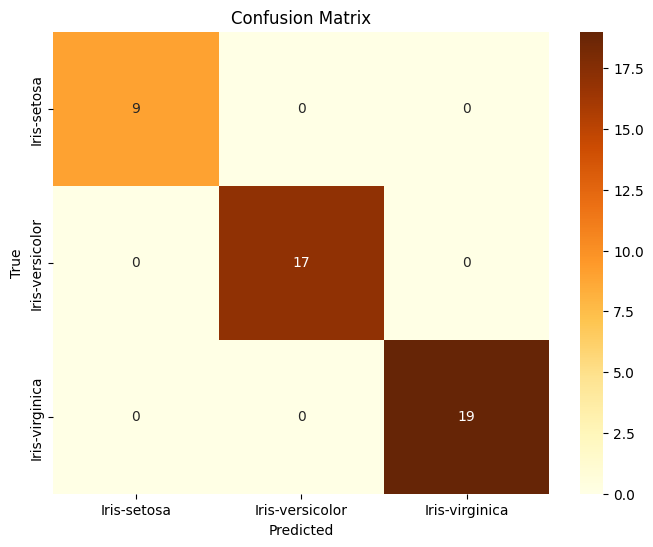

In [26]:
# После получения предсказаний (y_test и y_pred из предыдущего кода)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', 
            xticklabels=df['species'].unique(),
            yticklabels=df['species'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Как видно, модель действительно делает идеально точные прогнозы

### Развертывание модели в MLFlow

1. Вводим в командную строку: `mlflow server --host 127.0.0.1 --port 8080`
2. Переходим по адресу: `http://127.0.0.1:8080`

Продемонстрируем работу с MLFlow на примере TPOT

In [27]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")

mlflow.set_experiment("Iris_Classification_TPOT")

with mlflow.start_run():
    params = {
        'generations': 5,
        'population_size': 20,
        'random_state': 42,
        'verbosity': 2
    }
    
    mlflow.log_params(params)
    
    tpot = TPOTClassifier(**params)
    tpot.fit(X_train, y_train)
    
    with open(f'{directory}/tpot_model.pkl', 'wb') as f:
        pickle.dump(tpot.fitted_pipeline_, f)
    
    mlflow.log_artifact(f'{directory}/tpot_model.pkl')
    
    mlflow.sklearn.log_model(tpot.fitted_pipeline_, "sklearn_model")
    
    y_pred = tpot.predict(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted')
    }
    mlflow.log_metrics(metrics)
    
    print(f"Модель сохранена в tpot_model.pkl")

2025/03/31 20:39:15 INFO mlflow.tracking.fluent: Experiment with name 'Iris_Classification_TPOT' does not exist. Creating a new experiment.
Version 0.12.1 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


                                                                             
Generation 1 - Current best internal CV score: 0.9888888888888889
                                                                             
Generation 2 - Current best internal CV score: 0.9888888888888889
                                                                             
Generation 3 - Current best internal CV score: 0.9888888888888889
                                                                              
Generation 4 - Current best internal CV score: 0.9888888888888889
                                                                              
Generation 5 - Current best internal CV score: 0.9888888888888889
                                                                              
Best pipeline: MLPClassifier(input_matrix, alpha=0.001, learning_rate_init=0.01)


2025/03/31 20:39:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/31 20:39:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-wasp-502 at: http://127.0.0.1:8080/#/experiments/554819157492597828/runs/697bbf00e2984843b991928f83cd81a3.
2025/03/31 20:39:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/554819157492597828.


Модель сохранена в tpot_model.pkl


In [28]:
metrics

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0}